<h2>Median Filtering </h2>

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter


<h3>Read Image</h3>

In [2]:
image_path = '../images/lane2.jpeg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image_rgb.copy()

<h3>Apply Median Filter</h3>

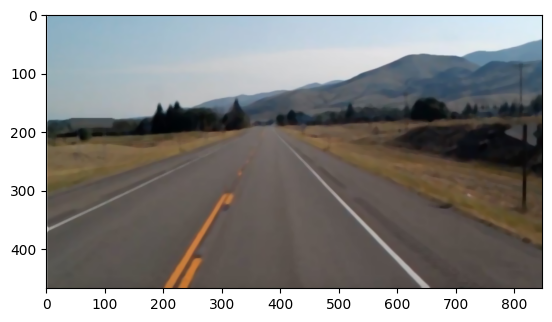

In [3]:
median_filter = cv2.medianBlur(image, 7)
plt.figure()
plt.imshow(median_filter)

plt.show()

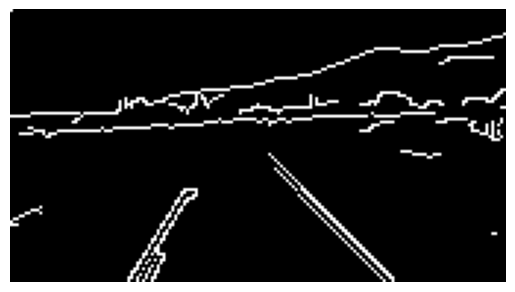

In [4]:

height, width, _ = median_filter.shape
scale = 1/5

height_scale = int(height * scale)
width_scale = int(width * scale)
img = cv2.resize(median_filter, (width_scale, height_scale), interpolation=cv2.INTER_LINEAR)

canny_edge = cv2.Canny(img, 200, 255)

plt.figure()
plt.imshow(canny_edge, cmap='gray')  
plt.axis('off')  
plt.show()


<h3>ROI</h3>

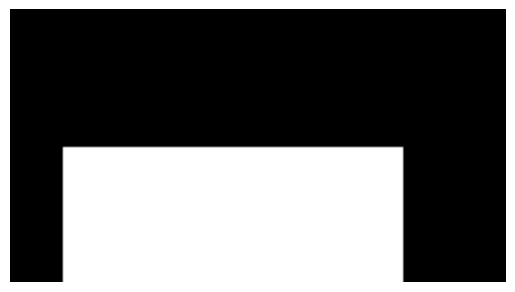

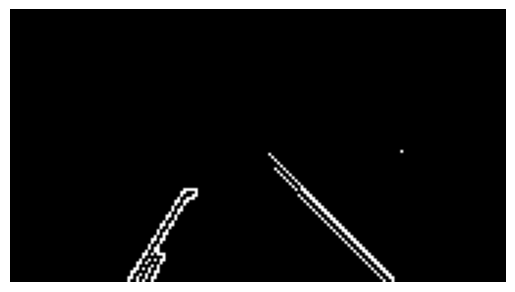

In [6]:
height, width = canny_edge.shape 


mask = np.zeros_like(canny_edge)

reduction1 = int(width * 0.3)
reduction2 = int(width * 0.4)

top_mask = np.array([[(0, 0), (width, 0), (width, height // 2), (0, height // 2)]], dtype=np.int32)
# Left mask covering the left half of the image
left_mask = np.array([[
    (0, 0),               # Top-left corner
    (width // 2 - reduction2, 0),      # Top-middle
    (width // 2 - reduction2, height), # Bottom-middle
    (0, height)           # Bottom-left corner
]], dtype=np.int32)

# Right mask covering the right half of the image
right_mask = np.array([[
    (width // 2 + reduction1, 0),      # Top-middle
    (width, 0),          # Top-right corner
    (width, height),     # Bottom-right corner
    (width // 2 + reduction1, height)  # Bottom-middle
]], dtype=np.int32)


cv2.fillPoly(mask, top_mask, 255)
cv2.fillPoly(mask, left_mask, 255)
cv2.fillPoly(mask, right_mask, 255)


mask = cv2.bitwise_not(mask)


masked_edges = cv2.bitwise_and(canny_edge, mask)

plt.figure()
plt.imshow(mask, cmap='gray')  
plt.axis('off')  
plt.show()

plt.figure()
plt.imshow(masked_edges, cmap='gray')  
plt.axis('off')  
plt.show()


<h3>Masked Image</h3>

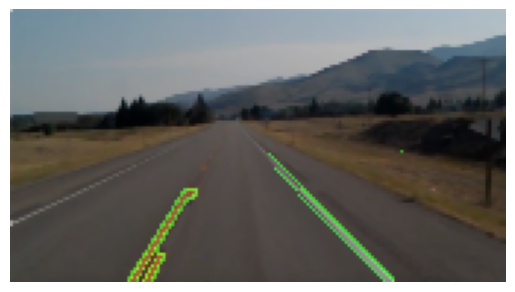

In [50]:
edges_colored = np.zeros_like(img)  
edges_colored[:, :, 1] = masked_edges 


highlighted = cv2.addWeighted(img, 0.8, edges_colored, 0.5, 0)

plt.figure()
plt.imshow(highlighted)
plt.axis('off')
plt.show()


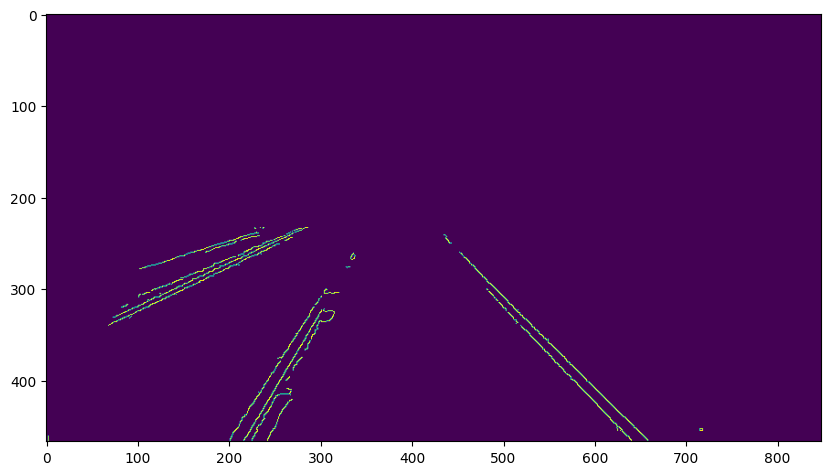

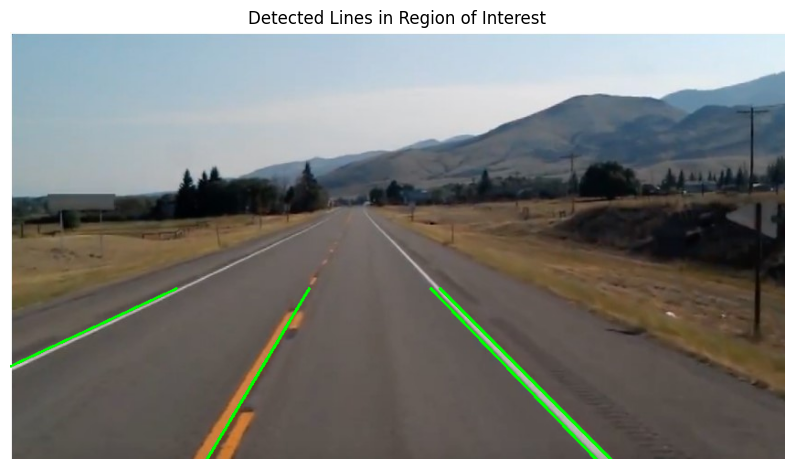

In [46]:
image = cv2.imread('../images/lane2.jpeg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.equalizeHist(gray)

height, width = gray.shape
mask = np.zeros_like(gray)  
# reduction1 = int(width * 0.3)
# reduction2 = int(width * 0.45)

edges = cv2.Canny(gray, 200, 255)

top_mask = np.array([[(0, height), (int(0.9*width), height), (int(0.5*width), int(0.5*height)), (int(0.15*width), int(0.5*height))]], dtype=np.int32)
# left_mask = np.array([[(0, 0), (width // 2 - reduction2, 0), (width // 2 - reduction2, height), (0, height)]], dtype=np.int32)
# right_mask = np.array([[(width // 2 + reduction1, 0), (width, 0), (width, height), (width // 2 + reduction1, height)]], dtype=np.int32)


cv2.fillPoly(mask, top_mask, 255)
# cv2.fillPoly(mask, left_mask, 255)
# cv2.fillPoly(mask, right_mask, 255)


# inverse_mask = cv2.bitwise_not(mask)
# inverse_masked_gray = cv2.bitwise_and(gray, inverse_mask)
# edges = cv2.Canny(inverse_masked_gray, 200, 255) 


mask = cv2.GaussianBlur(mask, (5, 5), 0)  

_, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)


inverse_masked_gray = cv2.bitwise_and(edges, mask)





rho_max = int(np.hypot(height, width))
theta_range = np.deg2rad(np.arange(0, 180))
accumulator = np.zeros((len(theta_range), 2 * rho_max), dtype=np.int32)

edge_points = np.argwhere(inverse_masked_gray > 0)


for y, x in edge_points:
    for theta_idx, theta in enumerate(theta_range):
        rho = int(x * np.cos(theta) + y * np.sin(theta))
        rho_idx = rho + rho_max
        accumulator[theta_idx, rho_idx] += 1


threshold = 130
strong_votes = np.argwhere(accumulator > threshold)


image_with_lines = image.copy()
for theta_idx, rho_idx in strong_votes:
    rho = rho_idx - rho_max
    theta = theta_range[theta_idx]

    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho

    # line_length = 1000 
    roi_top = int(0.6*height)
    roi_bottom = height
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    slope = -a / b  # Rearranged from x cos(θ) + y sin(θ) = ρ

    # Define the top and bottom y-coordinates of the ROI
    y1, y2 = roi_bottom, roi_top  # Bottom and top y of ROI

    # Compute the corresponding x-coordinates using the line equation
    x1 = int((y1 - y0) / slope + x0)
    x2 = int((y2 - y0) / slope + x0)

    # Draw the trimmed line
    cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)


image_with_lines_rgb = cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB)



edges = cv2.cvtColor(edges, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(10, 6))
plt.imshow(inverse_masked_gray)


plt.figure(figsize=(10, 6))
plt.imshow(image_with_lines_rgb)
plt.axis("off")
plt.title("Detected Lines in Region of Interest")
plt.show()


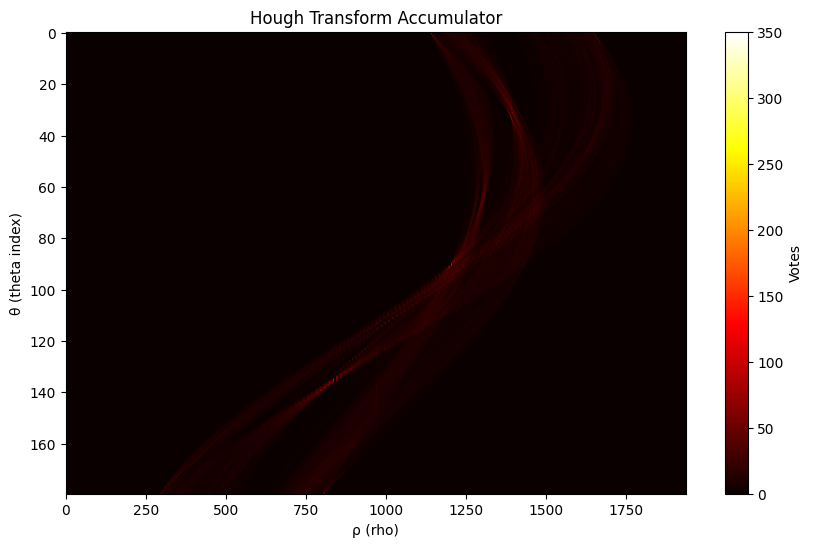

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(accumulator, cmap='hot', aspect='auto')
plt.colorbar(label="Votes")
plt.xlabel("ρ (rho)")
plt.ylabel("θ (theta index)")
plt.title("Hough Transform Accumulator")
plt.show()


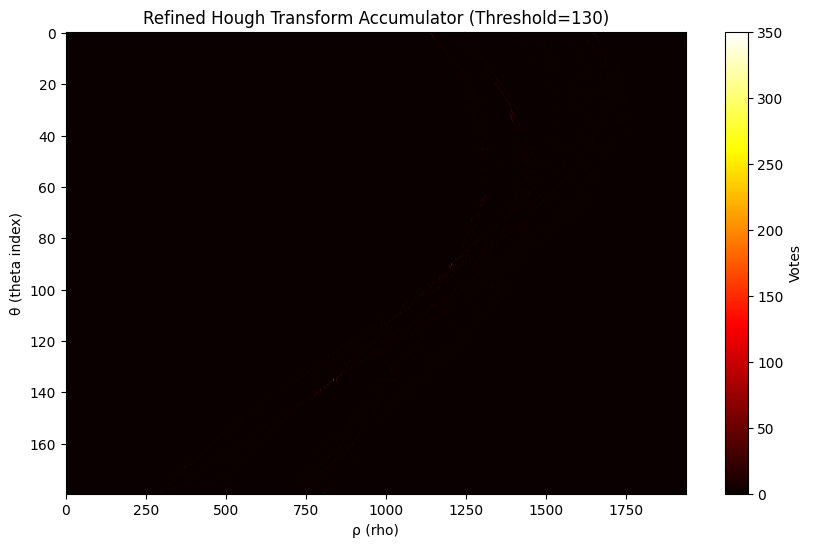

In [ ]:
nms_size = 5  
maxima = maximum_filter(accumulator, size=nms_size)
accumulator[accumulator < maxima] = 0 


plt.figure(figsize=(10, 6))
plt.imshow(accumulator, cmap='hot', aspect='auto')
plt.colorbar(label="Votes")
plt.xlabel("ρ (rho)")
plt.ylabel("θ (theta index)")
plt.title(f"Refined Hough Transform Accumulator (Threshold={threshold})")
plt.show()


